In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as T
from torchvision.transforms import functional
from torch.utils.data import RandomSampler, BatchSampler, SequentialSampler, random_split, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.jit import save, load, script
import numpy as np
import matplotlib.pyplot as plt

In [43]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv4 = nn.Conv2d(64, 64, 3, 1, 1)
        self.conv5 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv6 = nn.Conv2d(128, 128, 3, 1, 1)
        self.fc1 = nn.Linear(4*4*128, 128)
        self.fc2 = nn.Linear(128, 10)
        self.BN32 = nn.BatchNorm2d(32)
        self.BN64 = nn.BatchNorm2d(64)
        self.BN128 = nn.BatchNorm2d(128)
        self.BN1D = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.avgpool = nn.AvgPool2d(2)
        self.flatten = nn.Flatten()
        self.logsoftmax = nn.LogSoftmax(dim=1)

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = self.BN32(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = self.BN64(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = self.BN128(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.BN1D(x)
        x = self.fc2(x)
        output = self.logsoftmax(x)
        return output
    

def train(model, device, train_loader, optimizer, epoch, loss_history, acc_history):
    model.train()
    correct = 0
    total_loss = 0
    e = '='
    g = '>'
    m = '-'
    print(f'Train Epoch: {epoch}')
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total_loss += loss.item() 
        loss.backward()
        optimizer.step()
        avg_loss = total_loss / (batch_idx+1)
        acc = 100. * correct / len(train_loader.dataset)
        bar_num = int(20*(batch_idx+1)/len(train_loader))
        
        print(f'[{bar_num*e + g + (20-bar_num)*m}]({100.*batch_idx /len(train_loader):.0f}%)\tTraining Loss: {avg_loss:.4f}\t\tAccuracy: {acc:.2f}%', end = '\r')
    loss_history.append(avg_loss)
    acc_history.append(acc)
    print('')
    
def val(model, device, val_loader, loss_history, acc_history):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    val_loss /= len(val_loader.dataset)
    acc = 100. * correct / len(val_loader.dataset)
    
    print(f'\t\t\t\tValidation Loss: {val_loss:.4f}\t\tAccuracy: {acc:.2f}%')
    loss_history.append(val_loss)
    acc_history.append(acc)
    
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {acc:.2f}%')
    

    
# set random seed
torch.manual_seed(198964)

#set device
device = torch.device('cuda')

# arguments
batch_size = 64
test_batch_size = 1000
lr = 0.01
epochs = 500

# transform
train_tf=T.Compose([
#     T.Grayscale(3),
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation((-60, 60)),
    T.ColorJitter(0.1, 0.1, 0.1, 0.1),
    T.RandomCrop(32, padding=4),
    T.ToTensor(),
    T.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784))
])
eval_tf=T.Compose([
#     T.Grayscale(3),
    T.ToTensor(),
    T.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784))
])

# import data
train_data = datasets.CIFAR10(root='./data', train=True, download=True,
                              transform=train_tf)
test_data = datasets.CIFAR10(root='./data', train=False, download=True,
                             transform=eval_tf)
(test_data, val_data) = random_split(test_data, [5000, 5000])

# kwargs
train_kwargs = {'batch_sampler': BatchSampler(sampler=RandomSampler(train_data),
                                              batch_size=batch_size,
                                              drop_last=False),
                'num_workers':3}
val_kwargs = {'batch_sampler': BatchSampler(sampler=SequentialSampler(val_data),
                                              batch_size=test_batch_size,
                                              drop_last=False), 
              'num_workers':3}
test_kwargs = {'batch_sampler': BatchSampler(sampler=SequentialSampler(test_data),
                                              batch_size=test_batch_size,
                                              drop_last=False),
               'num_workers':3}

# dataloader
train_loader = DataLoader(train_data, **train_kwargs)
val_loader = DataLoader(val_data, **val_kwargs)
test_loader = DataLoader(test_data, **test_kwargs)

# build model
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []




Files already downloaded and verified
Files already downloaded and verified


In [44]:
for epoch in range(1, epochs+1):
    train(model, device, train_loader, optimizer, epoch, train_loss_history, train_acc_history)
    val(model, device, val_loader, val_loss_history, val_acc_history)
    scheduler.step()
    
test(model, device, test_loader)

Train Epoch: 1
[====================>](100%)	Training Loss: 1.8498		Accuracy: 32.51%
				Validation Loss: 1.5192		Accuracy: 43.66%
Train Epoch: 2
[====================>](100%)	Training Loss: 1.5808		Accuracy: 42.79%
				Validation Loss: 1.4074		Accuracy: 49.80%
Train Epoch: 3
[====================>](100%)	Training Loss: 1.4442		Accuracy: 47.97%
				Validation Loss: 1.5837		Accuracy: 50.94%
Train Epoch: 4
[====================>](100%)	Training Loss: 1.3368		Accuracy: 52.26%
				Validation Loss: 1.0773		Accuracy: 62.76%
Train Epoch: 5
[====================>](100%)	Training Loss: 1.2354		Accuracy: 55.82%
				Validation Loss: 1.0649		Accuracy: 62.48%
Train Epoch: 6
[====================>](100%)	Training Loss: 1.1613		Accuracy: 58.82%
				Validation Loss: 0.9362		Accuracy: 67.04%
Train Epoch: 7
[====================>](100%)	Training Loss: 1.0810		Accuracy: 61.83%
				Validation Loss: 0.8855		Accuracy: 68.90%
Train Epoch: 8
[====================>](100%)	Training Loss: 1.0292		Accuracy: 63.78

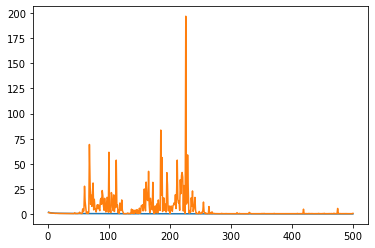

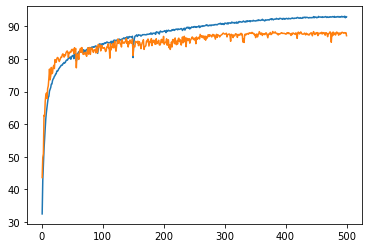

In [45]:
x = np.arange(1, epochs+1)
plt.plot(x, train_loss_history)
plt.plot(x, val_loss_history)
a = plt.subplots()
a = plt.plot(x, train_acc_history)
a = plt.plot(x, val_acc_history)

In [47]:
m = script(Net())
save(m, 'cifar10_module.pt')
torch.save(model.state_dict(), 'cifar10_state_dict.pt')

In [46]:
import matplotlib.pyplot

import PIL
from PIL import ImageShow

toIMG = T.ToPILImage(mode='RGB')

In [130]:
it = iter(train_loader)

In [131]:
data, label = it.next()

In [136]:
print(data[0][0])

tensor([[-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
        [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
        [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
        ...,
        [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
        [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
        [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686]])


In [71]:
img = toIMG(data[5])

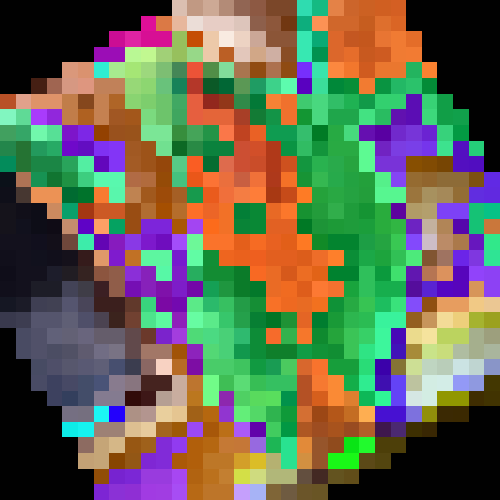

In [72]:
img.resize((500,500))

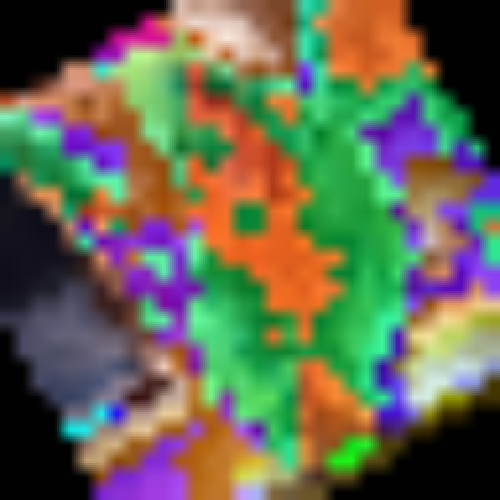

In [73]:
newIMG = T.Resize(256)(img)

newIMG.resize((500,500))

In [137]:
import numpy as np

In [150]:
r = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))])

In [152]:
print(train_data[30000])

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7FCA6A79F940>, 0)


In [155]:
mean = np.mean(r/255, axis=(0,1))

In [156]:
print(mean)

[0.49139968 0.48215841 0.44653091]


In [157]:
std = np.std(r/255, axis=(0,1))

In [158]:
print(std)

[0.24703223 0.24348513 0.26158784]
